# Grab our datasets to train the model

We will train on Cifar10 and other datasets, let's grab them and prepare them to train our Diffusion Model

In [19]:
import os, shutil, random
from types import SimpleNamespace
from pathlib import Path
from kaggle import api
import zipfile
import torch
import wandb
import torchvision
import torchvision.transforms as T
from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

## Helper funcs

In [11]:
def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [12]:
def untar_data(url, force_download=False, base='./datasets'):
    d = FastDownload(base=base)
    return d.get(url, force=force_download, extract_key='data')

In [13]:
def get_kaggle_dataset(dataset_path, # Local path to download dataset to
                dataset_slug, # Dataset slug (ie "zillow/zecon")
                unzip=True, # Should it unzip after downloading?
                force=False # Should it overwrite or error if dataset_path exists?
               ):
    '''Downloads an existing dataset and metadata from kaggle'''
    if not force and Path(dataset_path).exists():
        return Path(dataset_path)
    api.dataset_metadata(dataset_slug, str(dataset_path))
    api.dataset_download_files(dataset_slug, str(dataset_path))
    if unzip:
        zipped_file = Path(dataset_path)/f"{dataset_slug.split('/')[-1]}.zip"
        import zipfile
        with zipfile.ZipFile(zipped_file, 'r') as zip_ref:
            zip_ref.extractall(Path(dataset_path))
        zipped_file.unlink()

## Cifar

Our trusty Cifar dataset...

In [71]:
cifar_labels = "airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck".split(",")

In [14]:
def get_cifar(cifar100=False, img_size=64):
    "Download and extract CIFAR"
    cifar10_url = 'https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz'
    cifar100_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz'
    if img_size==32:
        return untar_data(cifar100_url if cifar100 else cifar10_url)
    else:
        get_kaggle_dataset("datasets/cifar10_64", "joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution")
        return Path("datasets/cifar10_64/cifar10-64")

In [15]:
path = get_cifar()

In [17]:
path

Path('datasets/cifar10_64/cifar10-64')

In [18]:
path.ls()

(#2) [Path('datasets/cifar10_64/cifar10-64/train'),Path('datasets/cifar10_64/cifar10-64/test')]

Let's log a version of the dataset to our project

In [20]:
at = wandb.Artifact("CIFAR10_64", type="dataset", 
                    description="The CIFAR10 datasets scaled to 64 pixels",  
                    metadata={"img_size":64, "url": "kaggle.com/joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution",
                              "labels":cifar_labels})

In [21]:
at.add_dir("datasets/cifar10_64/cifar10-64/")

wandb: Adding directory to artifact (./datasets/cifar10_64/cifar10-64)... Done. 65.5s


In [23]:
with wandb.init(project="train_sd", job_type="log_dataset"):
    wandb.log_artifact(at)

In [79]:
def get_cifar_data(dataset_path, img_size=64, batch_size=8, train_folder="train", val_folder="test", slice_size=-1, num_workers=4):
    train_transforms = torchvision.transforms.Compose([
        T.Resize(img_size + int(.25*img_size)),  # img_size + 1/4 *img_size
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    val_transforms = torchvision.transforms.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, train_folder), transform=train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, val_folder), transform=val_transforms)
    
    if slice_size>1:
        train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), slice_size))
        val_dataset = torch.utils.data.Subset(val_dataset, indices=range(0, len(val_dataset), slice_size))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_dataloader, val_dataset

Let's get a sample of 1/100th the total dataset... around 600/100 images

In [121]:
train_dl, val_dl = get_cifar_data(path, batch_size=256, slice_size=100)

In [122]:
train_batch = next(iter(train_dl))

In [123]:
x, y = train_batch

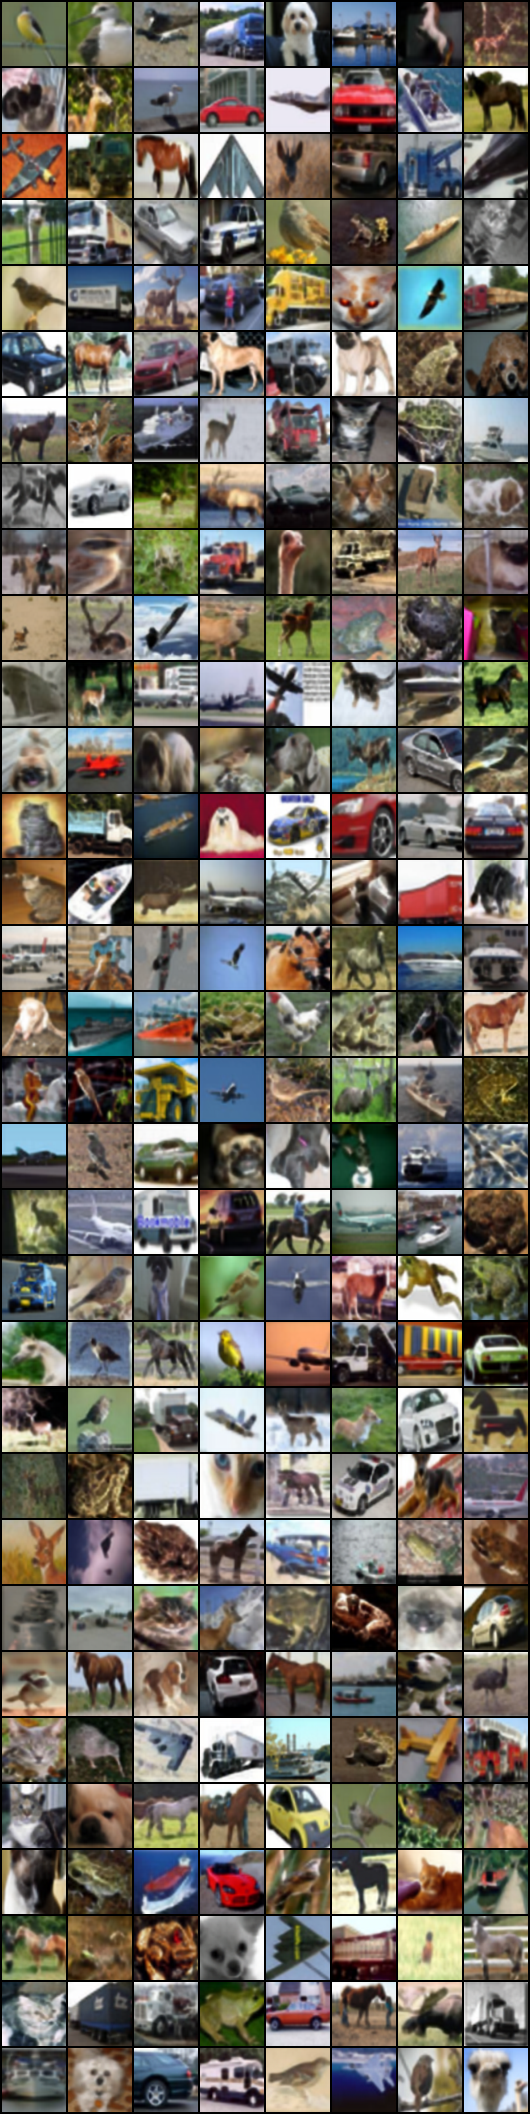

In [124]:
wandb.Image(x).image

create a wandb.Table

In [125]:
table = wandb.Table(columns=["image", "label_id", "label", "split"])

In [126]:
for img, label in iter(train_dl.dataset):
    table.add_data(wandb.Image(img), label, cifar_labels[label], "train")

In [127]:
for img, label in iter(val_dl.dataset):
    table.add_data(wandb.Image(img), label, cifar_labels[label], "valid")

log the table

In [128]:
with wandb.init(project="train_sd", group="cifar10", job_type="dataset_viz"):
    wandb.use_artifact('capecape/train_sd/CIFAR10_64:v0', type='dataset')
    wandb.log({"cifar_viz":table})

## There is "bug" here, someone can spot it?

The validation dataloader is not shuffling the data (this is normal). Then, we only get planes! we should probably log the full validation dataset...

## Fonts Dataset

In [129]:
def get_alphabet_dl(batch_size=8, num_workers=4, slice_size=-1):
    get_kaggle_dataset("datasets/alphabet", "thomasqazwsxedc/alphabet-characters-fonts-dataset")
    train_transforms = T.Compose([
        T.Grayscale(),
        T.ToTensor(),])
    train_dataset = torchvision.datasets.ImageFolder(root="./datasets/alphabet/Images/Images/", transform=train_transforms)
    if slice_size>1:
        train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), slice_size))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return train_dataloader, None

In [144]:
alphabet_labels = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z".split(" ")

In [ ]:
at = wandb.Artifact("Alphabet", type="dataset", 
                    description="A collection of 15k fonts in image format",  
                    metadata={"img_size":64, "url": "kaggle.com/thomasqazwsxedc/alphabet-characters-fonts-dataset",
                              "labels":alphabet_labels})

## didn't log, it's very big (300k files).

In [167]:
train_dl, _ = get_alphabet_dl(batch_size=128, slice_size=100)

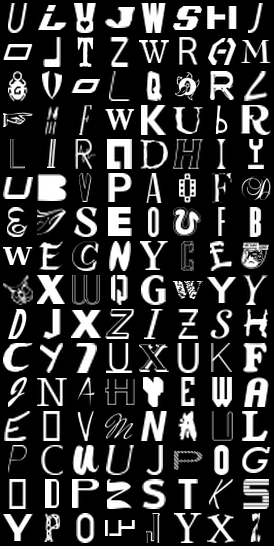

In [169]:
wandb.Image(next(iter(train_dl))[0]).image

In [173]:
table = wandb.Table(columns=["image", "label_id", "label", "split"])

In [174]:
for img, label in iter(train_dl.dataset):
    table.add_data(wandb.Image(img), label, alphabet_labels[label], "train")

log the table

In [172]:
with wandb.init(project="train_sd", group="alphabet", job_type="dataset_viz"):
    wandb.log({"alphabet_viz":table})